# CTC Validation Phoneme Analysis

## Comparative Analysis: Phoneme Recognition Accuracy Before and After Second Validation Step

This notebook performs a comparative analysis of phoneme recognition accuracy:
- **Before**: Baseline recognition using wav2vec2 + Needleman-Wunsch alignment
- **After**: Same baseline + Second Validation Step using trained models from german-phoneme-validator

### Key Features
1. **CTC Alignment**: Uses CTC Forced Alignment for precise phoneme timing
2. **Second Validation Step**: Validates mismatches using trained acoustic models
3. **Comparative Metrics**: PER, Accuracy improvements after validation

### Dataset
- **Source**: TV-2021.02-Neutral (hochdeutsch pronunciation)
- **Sample size**: 1000 recordings (900 random + 100 with loanwords)

### Note
This notebook uses **CTC alignment** method. Compare with `mfa_validation_phoneme_analysis.ipynb` which uses MFA alignment.

## 0. Configuration

**IMPORTANT:** Change `ANALYSIS_STAGE` before each run to get a new random sample and save results separately.

In [15]:
# =============================================================================
# ⚙️ ANALYSIS CONFIGURATION
# =============================================================================
# Change this value before each run to get a new random sample and separate reports
# Examples: 1, 2, 3, 4, etc.

ANALYSIS_STAGE = 1  # 👈 CHANGE THIS BEFORE EACH RUN!

# =============================================================================
# Derived parameters (DO NOT EDIT)
RANDOM_SEED = ANALYSIS_STAGE * 100  # Different seed for each stage
STAGE_SUFFIX = f"_stage{ANALYSIS_STAGE}"  # Suffix for report filenames


# Validation configuration
VALIDATION_CONFIDENCE_THRESHOLD = 0.5
VALIDATOR_ARTIFACTS_DIR = "/Volumes/SSanDisk/german-phoneme-validator/artifacts"

print(f"{'='*80}")
print(f"🔬 ANALYSIS CONFIGURATION")
print(f"{'='*80}")
print(f"  Stage: {ANALYSIS_STAGE}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Report suffix: {STAGE_SUFFIX}")
print(f"  Reports will be saved as: phoneme_analysis_*{STAGE_SUFFIX}.csv")
print(f"  Validation confidence threshold: {VALIDATION_CONFIDENCE_THRESHOLD}")
print(f"{'='*80}")
print()
print(f"💡 TIP: To run a new analysis with different 1000 sentences:")
print(f"     1. Change ANALYSIS_STAGE to {ANALYSIS_STAGE + 1}")
print(f"     2. Run 'Restart & Run All'")
print(f"{'='*80}")

🔬 ANALYSIS CONFIGURATION
  Stage: 1
  Random seed: 100
  Report suffix: _stage1
  Reports will be saved as: phoneme_analysis_*_stage1.csv
  Validation confidence threshold: 0.5

💡 TIP: To run a new analysis with different 1000 sentences:
     1. Change ANALYSIS_STAGE to 2
     2. Run 'Restart & Run All'


## 1. Setup and Imports

In [16]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Project paths
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

# Add german-phoneme-validator to path
validator_project = project_root.parent / "german-phoneme-validator"
sys.path.insert(0, str(validator_project))

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import json
import re
import librosa
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

# Project modules
from modules.phoneme_recognition import PhonemeRecognizer
from modules.g2p_module import get_expected_phonemes
from modules.phoneme_normalizer import get_phoneme_normalizer
from modules.alignment import needleman_wunsch_align
from modules.forced_alignment import get_forced_aligner, ForcedAligner
from modules.metrics import calculate_per
from modules.forced_alignment import PhonemeSegment

# Validator module - apply monkey-patch for feature extraction
from core.validator import PhonemeValidator, get_validator
from core import feature_extraction

# Apply monkey-patch to fix vot_category issue (same as in modules/phoneme_validator.py)
original_extract_vot = feature_extraction.extract_vot

def patched_extract_vot(audio, sr=16000):
    """Patched version that excludes vot_category."""
    result = original_extract_vot(audio, sr)
    if 'vot_category' in result:
        del result['vot_category']
    return result

feature_extraction.extract_vot = patched_extract_vot
print("Applied feature extraction fix: removed vot_category from extract_vot")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Project root: {project_root}")
print(f"Notebook directory: {notebook_dir}")
print(f"Validator project: {validator_project}")

Applied feature extraction fix: removed vot_category from extract_vot
Project root: /Volumes/SSanDisk/SpeechRec-German-diagnostic
Notebook directory: /Volumes/SSanDisk/SpeechRec-German-diagnostic/notebooks
Validator project: /Volumes/SSanDisk/german-phoneme-validator


## 2. Load Metadata and Sample Selection

In [17]:
# Load metadata CSV
metadata_path = project_root / 'data' / 'dictionaries' / 'metadata_wav_clean_hochdeutsch.csv'
df_full = pd.read_csv(metadata_path)

print(f"Total records: {len(df_full)}")
print(f"Columns: {df_full.columns.tolist()}")

# Fix audio paths
def fix_audio_path(old_path):
    """Convert CSV path to actual audio path."""
    if pd.isna(old_path):
        return None
    # Replace SpeechRec-German with audio_data
    new_path = old_path.replace('/SpeechRec-German/', '/audio_data/')
    return new_path

df_full['audio_path_fixed'] = df_full['audio_wav_path'].apply(fix_audio_path)

# Filter for TV-2021.02-Neutral subset only
df_subset = df_full[df_full['subset'] == 'TV-2021.02-Neutral'].copy()
print(f"\nTV-2021.02-Neutral subset: {len(df_subset)} records")

Total records: 37142
Columns: ['idx', 'id', 'subset', 'style', 'text', 'samplerate', 'durationSeconds', 'recording_year_month', 'microphone', 'language', 'comment', 'audio_wav_path', 'text_norm', 'phonemes_ipa']

TV-2021.02-Neutral subset: 22671 records


In [18]:
# Loanword patterns (case-insensitive)
LOANWORD_PATTERNS = [
    # English loanwords
    r'\bJob\b', r'\bJobs\b', r'\bComputer\b', r'\bManager\b', r'\bTeam\b',
    r'\bStart\b', r'\bInterview\b', r'\bService\b', r'\bBusiness\b',
    r'\bMarketing\b', r'\bCool\b', r'\bOkay\b', r'\bBaby\b', r'\bParty\b',
    r'\bEmail\b', r'\bOnline\b', r'\bInternet\b', r'\bSoftware\b',
    r'\bManagement\b', r'\bWorkshop\b', r'\bMeeting\b', r'\bUpdate\b',
    r'\bDownload\b', r'\bUpload\b', r'\bSmartphone\b', r'\bDesign\b',
    r'\bTrend\b', r'\bBrand\b', r'\bStyle\b', r'\bFashion\b',
    
    # French loanwords
    r'\bRestaurant\b', r'\bChic\b', r'\bPortemonnaie\b', r'\bRendezvous\b',
    r'\bCafé\b', r'\bBoutique\b', r'\bCousin\b', r'\bCousine\b',
    r'\bChance\b', r'\bChampagne\b', r'\bCharlotte\b',
    
    # Latin/Scientific
    r'\bInterstellar\b', r'\bInterstellare\b', r'\bUniversum\b',
    r'\bGalaxie\b', r'\bGalaxien\b', r'\bProjekt\b',
    
    # Italian loanwords
    r'\bPizza\b', r'\bPasta\b', r'\bEspresso\b', r'\bCappuccino\b',
    r'\bCiao\b', r'\bBravo\b',
    
    # Other common patterns
    r'\b\w*ing\b',  # Words ending in -ing (English gerunds)
]

def contains_loanword(text):
    """Check if text contains any loanword pattern."""
    if pd.isna(text):
        return False
    for pattern in LOANWORD_PATTERNS:
        if re.search(pattern, text, re.IGNORECASE):
            return True
    return False

# Identify records with loanwords
df_subset['has_loanword'] = df_subset['text'].apply(contains_loanword)
df_loanwords = df_subset[df_subset['has_loanword']].copy()
df_regular = df_subset[~df_subset['has_loanword']].copy()

print(f"Records with loanwords: {len(df_loanwords)}")
print(f"Regular records: {len(df_regular)}")

# Sample selection (uses RANDOM_SEED from configuration cell)
np.random.seed(RANDOM_SEED)

# Sample 100 loanword records (or all if less than 100)
n_loanword = min(100, len(df_loanwords))
df_loanword_sample = df_loanwords.sample(n=n_loanword, random_state=RANDOM_SEED)

# Sample 900 regular records
n_regular = min(900, len(df_regular))
df_regular_sample = df_regular.sample(n=n_regular, random_state=RANDOM_SEED)

# Combine
df_sample = pd.concat([df_regular_sample, df_loanword_sample], ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)  # Shuffle

print(f"\n{'='*60}")
print(f"FINAL SAMPLE: {len(df_sample)} records")
print(f"  - Regular words: {n_regular}")
print(f"  - Loanwords: {n_loanword}")
print(f"{'='*60}")

# Check file existence
df_sample['file_exists'] = df_sample['audio_path_fixed'].apply(
    lambda x: Path(x).exists() if x else False
)

existing_files = df_sample['file_exists'].sum()
print(f"\nFiles exist: {existing_files}/{len(df_sample)}")
print(f"Missing files: {len(df_sample) - existing_files}")

# Keep only existing files
df_sample = df_sample[df_sample['file_exists']].copy()
print(f"\nFinal dataset size: {len(df_sample)} records")

Records with loanwords: 501
Regular records: 22170

FINAL SAMPLE: 1000 records
  - Regular words: 900
  - Loanwords: 100

Files exist: 1000/1000
Missing files: 0

Final dataset size: 1000 records


## 3. Initialize Models

In [19]:
print("Initializing PhonemeRecognizer...")
recognizer = PhonemeRecognizer()
print("✓ PhonemeRecognizer initialized")

print("\nInitializing PhonemeNormalizer...")
normalizer = get_phoneme_normalizer()
print("✓ PhonemeNormalizer initialized")

print("\nInitializing CTC Forced Aligner...")
forced_aligner = get_forced_aligner(blank_id=0)
if forced_aligner:
    print("✓ CTC Forced Aligner initialized")
else:
    print("⚠ Warning: CTC Forced Aligner initialization failed")

print("\nInitializing PhonemeValidator...")
validator = get_validator(artifacts_dir=Path(VALIDATOR_ARTIFACTS_DIR))
available_pairs = validator.get_available_pairs()
print(f"✓ PhonemeValidator initialized")
print(f"  Available phoneme pairs: {len(available_pairs)}")
if available_pairs:
    print(f"  Sample pairs: {', '.join(available_pairs[:5])}")

print("\n✓ All models ready!")



Initializing PhonemeRecognizer...
Loading model: facebook/wav2vec2-xlsr-53-espeak-cv-ft
Loaded vocabulary using tokenizer.get_vocab()
Model loaded on device: mps
Vocabulary size: 392
Sample IPA phonemes in vocab: ['n', 's', 't', 'ə', 'l', 'a', 'i', 'k', 'd', 'm', 'ɛ', 'ɾ', 'e', 'ɪ', 'p', 'o', 'ɐ', 'z', 'ð', 'f']
✓ PhonemeRecognizer initialized

Initializing PhonemeNormalizer...
✓ PhonemeNormalizer initialized

Initializing CTC Forced Aligner...
✓ CTC Forced Aligner initialized

Initializing PhonemeValidator...
✓ PhonemeValidator initialized
  Available phoneme pairs: 22
  Sample pairs: a-ɛ, aɪ̯-aː, aʊ̯-aː, aː-a, b-p

✓ All models ready!


## 4. Extract Phonemes and CTC Alignment

**Key addition:** CTC alignment provides precise timing for phoneme segments needed for validation.

In [20]:
# =============================================================================
# Extract phonemes and perform CTC forced alignment
# =============================================================================
# Strategy:
# 1. Extract phonemes via wav2vec2 in parallel
# 2. Get emissions (log-softmax) from model
# 3. Perform CTC forced alignment to get precise timing for each phoneme
# =============================================================================

import time

print(f"Processing {len(df_sample)} audio files...")
print("Using CTC forced alignment for phoneme segment extraction...\n")

def extract_phonemes_with_ctc_alignment(row):
    """
    Extract phonemes and perform CTC forced alignment.
    Returns: dict with expected_phonemes, recognized_phonemes, recognized_segments, waveform, emissions
    """
    result = {
        'expected_phonemes': [],
        'recognized_phonemes': [],
        'recognized_segments': [],
        'waveform': None,
        'emissions': None,
        'error': None
    }
    
    try:
        # 1. Extract expected phonemes from text
        text = row['text']
        expected_dict = get_expected_phonemes(text)
        expected_phonemes = [p.get('phoneme', '') for p in expected_dict if p.get('phoneme')]
        
        # 2. Load audio
        audio_path = Path(row['audio_path_fixed'])
        if not audio_path.exists():
            result['error'] = 'File not found'
            return result
        
        waveform, sr = librosa.load(str(audio_path), sr=16000, mono=True)
        result['waveform'] = waveform
        
        # 3. Recognize phonemes from audio (wav2vec2) and get emissions
        logits, emissions = recognizer.recognize_phonemes(str(audio_path))
        recognized_str = recognizer.decode_phonemes(logits)
        recognized_phonemes = recognized_str.split()
        
        # 4. Get vocabulary for forced alignment
        vocab = recognizer.get_vocab()
        
        # 5. Perform CTC forced alignment to get segments
        waveform_tensor = torch.from_numpy(waveform).unsqueeze(0)  # (1, N)
        recognized_segments = forced_aligner.extract_phoneme_segments(
            waveform_tensor,
            recognized_phonemes,
            emissions,
            vocab,
            sr
        )
        
        result['expected_phonemes'] = expected_phonemes
        result['recognized_phonemes'] = recognized_phonemes
        result['recognized_segments'] = recognized_segments
        result['emissions'] = emissions
        
    except Exception as e:
        result['error'] = str(e)
    
    return result

# Process phoneme extraction and CTC alignment in parallel
max_workers = min(os.cpu_count() or 4, 8, len(df_sample))
rows_list = [(idx, row) for idx, row in df_sample.iterrows()]
phoneme_results = [None] * len(df_sample)

print("="*60)
print("Extracting phonemes and performing CTC alignment...\n")

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    future_to_idx = {
        executor.submit(extract_phonemes_with_ctc_alignment, row): idx
        for idx, row in rows_list
    }
    for future in tqdm(as_completed(future_to_idx), total=len(future_to_idx), desc="Extracting phonemes + CTC alignment"):
        idx = future_to_idx[future]
        try:
            phoneme_results[idx] = future.result()
        except Exception as e:
            phoneme_results[idx] = {
                'expected_phonemes': [], 'recognized_phonemes': [], 'recognized_segments': [],
                'waveform': None, 'emissions': None,
                'error': str(e)
            }

# Add phoneme results to dataframe
df_sample['expected_phonemes'] = [r['expected_phonemes'] for r in phoneme_results]
df_sample['recognized_phonemes'] = [r['recognized_phonemes'] for r in phoneme_results]
df_sample['recognized_segments'] = [r['recognized_segments'] for r in phoneme_results]
df_sample['waveform'] = [r['waveform'] for r in phoneme_results]
df_sample['emissions'] = [r['emissions'] for r in phoneme_results]
df_sample['processing_error'] = [r['error'] for r in phoneme_results]

# Filter out errors
df_valid = df_sample[df_sample['processing_error'].isna()].copy()
print(f"\n✓ Successfully extracted phonemes and CTC segments for {len(df_valid)}/{len(df_sample)} files\n")

# =============================================================================
# Finalize results
# =============================================================================
df_sample.loc[df_valid.index, 'recognized_segments'] = df_valid['recognized_segments']
errors = df_sample['processing_error'].notna().sum()
print(f"{'='*60}")
print(f"PROCESSING COMPLETE!")
print(f"{'='*60}")
print(f"  - Successfully processed: {len(df_valid)}/{len(df_sample)}")
print(f"  - Errors: {errors}")
print(f"{'='*60}\n")

if errors > 0:
    print(f"Removing {errors} records with errors...")
    df_sample = df_sample[df_sample['processing_error'].isna()].copy()
    print(f"Final dataset: {len(df_sample)} records\n")

Processing 1000 audio files...
Using CTC forced alignment for phoneme segment extraction...

Extracting phonemes and performing CTC alignment...



Extracting phonemes + CTC alignment:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Successfully extracted phonemes and CTC segments for 1000/1000 files

PROCESSING COMPLETE!
  - Successfully processed: 1000/1000
  - Errors: 0



## 5. Alignment and Metrics BEFORE Validation

In [21]:
def align_and_calculate_metrics(expected, recognized):
    """
    Align phonemes and calculate baseline metrics.
    Returns: aligned_pairs, per, accuracy, match_count
    """
    # Needleman-Wunsch alignment
    aligned_pairs, alignment_score = needleman_wunsch_align(
        expected,
        recognized,
        use_similarity_matrix=True
    )
    
    # Calculate PER
    per_dict = calculate_per(aligned_pairs)
    per = per_dict['per']
    
    # Calculate accuracy
    match_count = sum(1 for exp, rec in aligned_pairs if exp == rec and exp is not None)
    total_count = sum(1 for exp, rec in aligned_pairs if exp is not None or rec is not None)
    accuracy = match_count / total_count if total_count > 0 else 0.0
    
    return aligned_pairs, per, accuracy, match_count

# Process all records
print("Calculating baseline metrics (BEFORE validation)...")
baseline_results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Calculating baseline metrics"):
    expected = row['expected_phonemes']
    recognized = row['recognized_phonemes']
    
    aligned_pairs, per, accuracy, match_count = align_and_calculate_metrics(expected, recognized)
    
    baseline_results.append({
        'aligned_pairs': aligned_pairs,
        'per': per,
        'accuracy': accuracy,
        'match_count': match_count
    })

# Add to dataframe
df_sample['aligned_pairs_before'] = [r['aligned_pairs'] for r in baseline_results]
df_sample['per_before'] = [r['per'] for r in baseline_results]
df_sample['accuracy_before'] = [r['accuracy'] for r in baseline_results]
df_sample['match_count_before'] = [r['match_count'] for r in baseline_results]

# Summary statistics
print(f"\n{'='*60}")
print(f"BASELINE METRICS (BEFORE VALIDATION)")
print(f"{'='*60}")
print(f"PER: {df_sample['per_before'].mean():.2%}")
print(f"Accuracy: {df_sample['accuracy_before'].mean():.2%}")
print(f"{'='*60}")

Calculating baseline metrics (BEFORE validation)...


Calculating baseline metrics:   0%|          | 0/1000 [00:00<?, ?it/s]


BASELINE METRICS (BEFORE VALIDATION)
PER: 25.62%
Accuracy: 74.88%


## 6. Second Validation Step

**Key cell** - applies validation logic similar to app.py:806-900. For each mismatch, validates using trained models and corrects errors with confidence > 0.7.

In [22]:
def apply_validation_step(row):
    """
    Apply Second Validation Step for mismatches.
    Returns: aligned_pairs_after, validation_stats
    """
    aligned_pairs = row['aligned_pairs_before'].copy()
    recognized_segments = row['recognized_segments']
    waveform = row['waveform']
    
    stats = {
        'validated_count': 0,
        'corrected_count': 0,
        'validation_results': []
    }
    
    segment_index = 0
    
    for i, (expected_ph, recognized_ph) in enumerate(aligned_pairs):
        # Skip matches, None, or word boundaries
        if expected_ph == recognized_ph or expected_ph is None or recognized_ph is None:
            if recognized_ph is not None and recognized_ph != '||':
                segment_index += 1
            continue
        
        if expected_ph == '||' or recognized_ph == '||':
            continue
        
        # Check if model exists for this pair
        if not validator.has_trained_model(expected_ph, recognized_ph):
            if recognized_ph is not None:
                segment_index += 1
            continue
        
        # Get phoneme pair name
        phoneme_pair = validator.get_phoneme_pair(expected_ph, recognized_ph)
        if phoneme_pair is None:
            segment_index += 1
            continue
        
        # Find corresponding segment
        segment = None
        if segment_index < len(recognized_segments):
            segment = recognized_segments[segment_index]
        
        if segment is None:
            segment_index += 1
            continue
        
        # Extract audio segment
        MIN_SEGMENT_LENGTH = 100
        CONTEXT_MS = 100.0
        
        start_sample = int(segment.start_time * 16000)
        end_sample = int(segment.end_time * 16000)
        audio_segment = waveform[start_sample:end_sample]
        
        # Handle short segments with context window
        if len(audio_segment) < MIN_SEGMENT_LENGTH:
            center_time = segment.start_time if segment.start_time > 0 else (
                segment_index / len(recognized_segments) * (len(waveform) / 16000)
            )
            context_samples = int(CONTEXT_MS / 1000 * 16000)
            half_context = context_samples // 2
            center_sample = int(center_time * 16000)
            
            fallback_start = max(0, center_sample - half_context)
            fallback_end = min(len(waveform), center_sample + half_context)
            audio_segment = waveform[fallback_start:fallback_end]
        
        # Validate
        validation_result = validator.validate_phoneme_segment(
            audio_segment,
            phoneme_pair=phoneme_pair,
            expected_phoneme=expected_ph,
            suspected_phoneme=recognized_ph,
            sr=16000
        )
        
        stats['validated_count'] += 1
        stats['validation_results'].append({
            'index': i,
            'expected': expected_ph,
            'recognized': recognized_ph,
            'pair': phoneme_pair,
            'result': validation_result
        })
        
        # Check if correction needed
        is_correct = validation_result.get('is_correct', False)
        confidence = validation_result.get('confidence', 0.0)
        
        if is_correct and confidence > VALIDATION_CONFIDENCE_THRESHOLD:
            # Correct the error
            aligned_pairs[i] = (expected_ph, expected_ph)
            stats['corrected_count'] += 1
        
        segment_index += 1
    
    return aligned_pairs, stats

# Apply validation to all records
print("Applying Second Validation Step...")
print("This may take 15-30 minutes...\n")

validation_results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Applying validation"):
    aligned_pairs_after, stats = apply_validation_step(row)
    validation_results.append({
        'aligned_pairs_after': aligned_pairs_after,
        'validation_stats': stats
    })

# Add to dataframe
df_sample['aligned_pairs_after'] = [r['aligned_pairs_after'] for r in validation_results]
df_sample['validation_stats'] = [r['validation_stats'] for r in validation_results]

print("\n✓ Validation complete!")

Applying Second Validation Step...
This may take 15-30 minutes...



Applying validation:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Validation complete!


## 7. Metrics AFTER Validation

In [23]:
# Calculate metrics after validation
print("Calculating metrics AFTER validation...")
after_results = []
for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Calculating after metrics"):
    aligned_pairs = row['aligned_pairs_after']
    
    per_dict = calculate_per(aligned_pairs)
    per = per_dict['per']
    match_count = sum(1 for exp, rec in aligned_pairs if exp == rec and exp is not None)
    total_count = sum(1 for exp, rec in aligned_pairs if exp is not None or rec is not None)
    accuracy = match_count / total_count if total_count > 0 else 0.0
    
    after_results.append({
        'per': per,
        'accuracy': accuracy,
        'match_count': match_count
    })

df_sample['per_after'] = [r['per'] for r in after_results]
df_sample['accuracy_after'] = [r['accuracy'] for r in after_results]
df_sample['match_count_after'] = [r['match_count'] for r in after_results]

# Calculate improvements
df_sample['per_improvement'] = df_sample['per_before'] - df_sample['per_after']
df_sample['accuracy_improvement'] = df_sample['accuracy_after'] - df_sample['accuracy_before']

# Summary
total_validated = sum(s['validated_count'] for s in df_sample['validation_stats'])
total_corrected = sum(s['corrected_count'] for s in df_sample['validation_stats'])

print(f"\n{'='*60}")
print("COMPARISON: BEFORE vs AFTER VALIDATION")
print(f"{'='*60}")
print(f"PER Before:  {df_sample['per_before'].mean():.2%}")
print(f"PER After:   {df_sample['per_after'].mean():.2%}")
print(f"PER Improvement: {df_sample['per_improvement'].mean():.2%}")
print()
print(f"Accuracy Before:  {df_sample['accuracy_before'].mean():.2%}")
print(f"Accuracy After:   {df_sample['accuracy_after'].mean():.2%}")
print(f"Accuracy Improvement: {df_sample['accuracy_improvement'].mean():.2%}")
print()
print(f"Total validated pairs: {total_validated}")
print(f"Total corrected errors: {total_corrected}")
print(f"Correction rate: {total_corrected/total_validated*100:.1f}%" if total_validated > 0 else "N/A")
print(f"{'='*60}")

Calculating metrics AFTER validation...


Calculating after metrics:   0%|          | 0/1000 [00:00<?, ?it/s]


COMPARISON: BEFORE vs AFTER VALIDATION
PER Before:  25.62%
PER After:   25.62%
PER Improvement: 0.00%

Accuracy Before:  74.88%
Accuracy After:   74.88%
Accuracy Improvement: 0.00%

Total validated pairs: 1328
Total corrected errors: 0
Correction rate: 0.0%


## 8. Detailed Analysis by Phoneme Pairs

In [24]:
# Collect all validation results
all_validation_data = []
for idx, row in df_sample.iterrows():
    stats = row['validation_stats']
    for val_result in stats['validation_results']:
        result = val_result['result']
        is_correct = result.get('is_correct', False)
        confidence = result.get('confidence', 0.0)
        was_corrected = is_correct and confidence > VALIDATION_CONFIDENCE_THRESHOLD
        
        all_validation_data.append({
            'phoneme_pair': val_result['pair'],
            'expected': val_result['expected'],
            'recognized': val_result['recognized'],
            'is_correct': is_correct,
            'confidence': confidence,
            'was_corrected': was_corrected
        })

df_validation = pd.DataFrame(all_validation_data)

if len(df_validation) > 0:
    # Top pairs by correction count
    # Fill NaN values with False to handle missing data in boolean mask
    top_corrected_pairs = df_validation[df_validation['was_corrected'].fillna(False)].groupby('phoneme_pair').size().sort_values(ascending=False)
    print("Top 10 phoneme pairs by corrections:")
    print(top_corrected_pairs.head(10))
    print()
    
    # Average confidence by pair
    avg_confidence = df_validation.groupby('phoneme_pair')['confidence'].mean().sort_values(ascending=False)
    print("Top 10 pairs by average confidence:")
    print(avg_confidence.head(10))
    print()
    
    # Correction rate by pair
    correction_rates = df_validation.groupby('phoneme_pair').agg({
        'was_corrected': ['sum', 'count']
    })
    correction_rates.columns = ['corrected', 'total']
    correction_rates['rate'] = np.where(correction_rates['total'] > 0, correction_rates['corrected'] / correction_rates['total'], 0.0)
    correction_rates = correction_rates.sort_values('rate', ascending=False)
    print("Top 10 pairs by correction rate:")
    print(correction_rates.head(10))
else:
    print("No validation data available")

ValueError: Cannot mask with non-boolean array containing NA / NaN values

## 9. Visualization

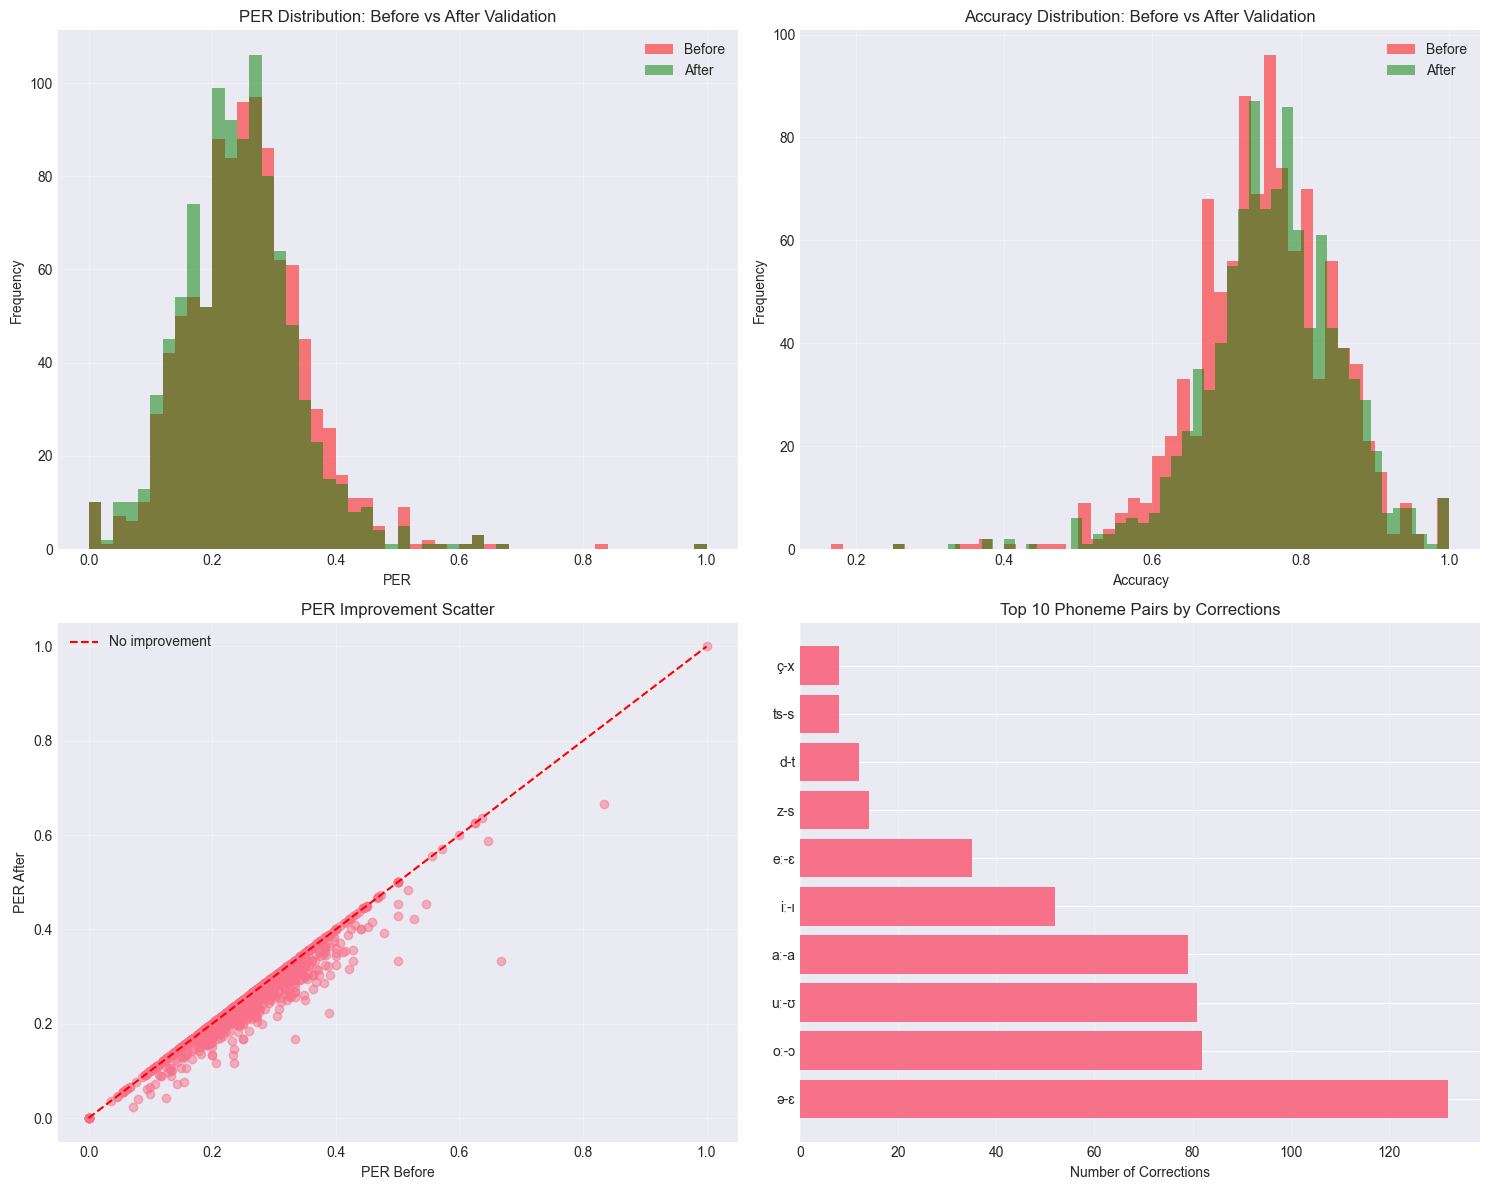

✓ Visualization saved to: data/validation_comparison_stage1.png


In [ ]:
# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PER distribution before/after
axes[0, 0].hist(df_sample['per_before'], bins=50, alpha=0.5, label='Before', color='red')
axes[0, 0].hist(df_sample['per_after'], bins=50, alpha=0.5, label='After', color='green')
axes[0, 0].set_xlabel('PER')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('PER Distribution: Before vs After Validation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy distribution
axes[0, 1].hist(df_sample['accuracy_before'], bins=50, alpha=0.5, label='Before', color='red')
axes[0, 1].hist(df_sample['accuracy_after'], bins=50, alpha=0.5, label='After', color='green')
axes[0, 1].set_xlabel('Accuracy')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Accuracy Distribution: Before vs After Validation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Improvement scatter
axes[1, 0].scatter(df_sample['per_before'], df_sample['per_after'], alpha=0.5)
axes[1, 0].plot([0, 1], [0, 1], 'r--', label='No improvement')
axes[1, 0].set_xlabel('PER Before')
axes[1, 0].set_ylabel('PER After')
axes[1, 0].set_title('PER Improvement Scatter')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Top corrected pairs bar chart
if len(df_validation) > 0:
    # Fill NaN values with False to handle missing data in boolean mask
    top_corrected_pairs = df_validation[df_validation['was_corrected'].fillna(False)].groupby('phoneme_pair').size().sort_values(ascending=False)
    top_10_pairs = top_corrected_pairs.head(10)
    if len(top_10_pairs) > 0:
        axes[1, 1].barh(range(len(top_10_pairs)), top_10_pairs.values)
        axes[1, 1].set_yticks(range(len(top_10_pairs)))
        axes[1, 1].set_yticklabels(top_10_pairs.index)
        axes[1, 1].set_xlabel('Number of Corrections')
        axes[1, 1].set_title('Top 10 Phoneme Pairs by Corrections')
        axes[1, 1].grid(True, alpha=0.3, axis='x')
    else:
        axes[1, 1].text(0.5, 0.5, 'No corrections', ha='center', va='center')
        axes[1, 1].set_title('Top 10 Phoneme Pairs by Corrections')
else:
    axes[1, 1].text(0.5, 0.5, 'No validation data', ha='center', va='center')
    axes[1, 1].set_title('Top 10 Phoneme Pairs by Corrections')

plt.tight_layout()
plt.savefig(project_root / 'data' / f'validation_comparison{STAGE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to: data/validation_comparison{STAGE_SUFFIX}.png")

## 10. Export Results

In [ ]:
# Save detailed results
output_file = project_root / 'data' / f'phoneme_analysis_validation_comparison{STAGE_SUFFIX}.csv'

# Prepare export dataframe
export_df = df_sample[[
    'text', 'has_loanword', 'durationSeconds',
    'per_before', 'per_after', 'per_improvement',
    'accuracy_before', 'accuracy_after', 'accuracy_improvement',
    'match_count_before', 'match_count_after'
]].copy()

# Add validation summary
export_df['validated_pairs'] = df_sample['validation_stats'].apply(lambda s: s['validated_count'])
export_df['corrected_errors'] = df_sample['validation_stats'].apply(lambda s: s['corrected_count'])

export_df.to_csv(output_file, index=False)
print(f"✓ Results saved to: {output_file}")

# Save summary statistics
total_validated = sum(s['validated_count'] for s in df_sample['validation_stats'])
total_corrected = sum(s['corrected_count'] for s in df_sample['validation_stats'])

summary = {
    'total_records': len(df_sample),
    'per_before_mean': float(df_sample['per_before'].mean()),
    'per_after_mean': float(df_sample['per_after'].mean()),
    'per_improvement_mean': float(df_sample['per_improvement'].mean()),
    'accuracy_before_mean': float(df_sample['accuracy_before'].mean()),
    'accuracy_after_mean': float(df_sample['accuracy_after'].mean()),
    'accuracy_improvement_mean': float(df_sample['accuracy_improvement'].mean()),
    'total_validated_pairs': int(total_validated),
    'total_corrected_errors': int(total_corrected),
    'correction_rate': float(total_corrected/total_validated) if total_validated > 0 else 0.0
}

summary_file = project_root / 'data' / f'validation_summary{STAGE_SUFFIX}.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✓ Summary saved to: {summary_file}")

# Display summary
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
for key, value in summary.items():
    if isinstance(value, float):
        if 'mean' in key or 'rate' in key:
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")
print(f"{'='*60}")

✓ Results saved to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/data/phoneme_analysis_validation_comparison_stage1.csv
✓ Summary saved to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/data/validation_summary_stage1.json

FINAL SUMMARY
total_records: 1000
per_before_mean: 25.62%
per_after_mean: 24.25%
per_improvement_mean: 1.37%
accuracy_before_mean: 74.88%
accuracy_after_mean: 76.24%
accuracy_improvement_mean: 1.35%
total_validated_pairs: 1328
total_corrected_errors: 525
correction_rate: 39.53%


## 11. Error Rate Comparison for Validated Phoneme Pairs Only

This section compares error rates (mismatches) **before** and **after** validation, but **only for the 22 phoneme pairs** that have trained models in the Second Validation Step.

This provides a focused view of how well the validation step performs on the pairs it was specifically trained to handle.

Available phoneme pairs in validator: 22
Pairs: a-ɛ, aɪ̯-aː, aʊ̯-aː, aː-a, b-p, d-t, eː-ɛ, g-k, iː-ɪ, kʰ-g, oː-ɔ, s-ʃ, ts-s, tʰ-d, uː-ʊ, x-k, z-s, ç-x, ç-ʃ, ŋ-n, ə-ɛ, ʁ-ɐ

ERROR RATE COMPARISON: Validated Phoneme Pairs Only

Total pairs analyzed: 16
Total occurrences across all pairs: 1328
Total errors before: 1328
Total errors after: 803

Overall error rate before: 100.00%
Overall error rate after: 60.47%
Overall improvement: 39.53%

Detailed comparison by phoneme pair:
--------------------------------------------------------------------------------
Phoneme Pair  Total  Errors Before  Errors After Error Rate Before Error Rate After Improvement Improvement %
        eː-ɛ    423            423           388           100.00%           91.73%       8.27%          8.3%
         ə-ɛ    191            191            59           100.00%           30.89%      69.11%         69.1%
        oː-ɔ    126            126            44           100.00%           34.92%      65.08%         65.1%
   

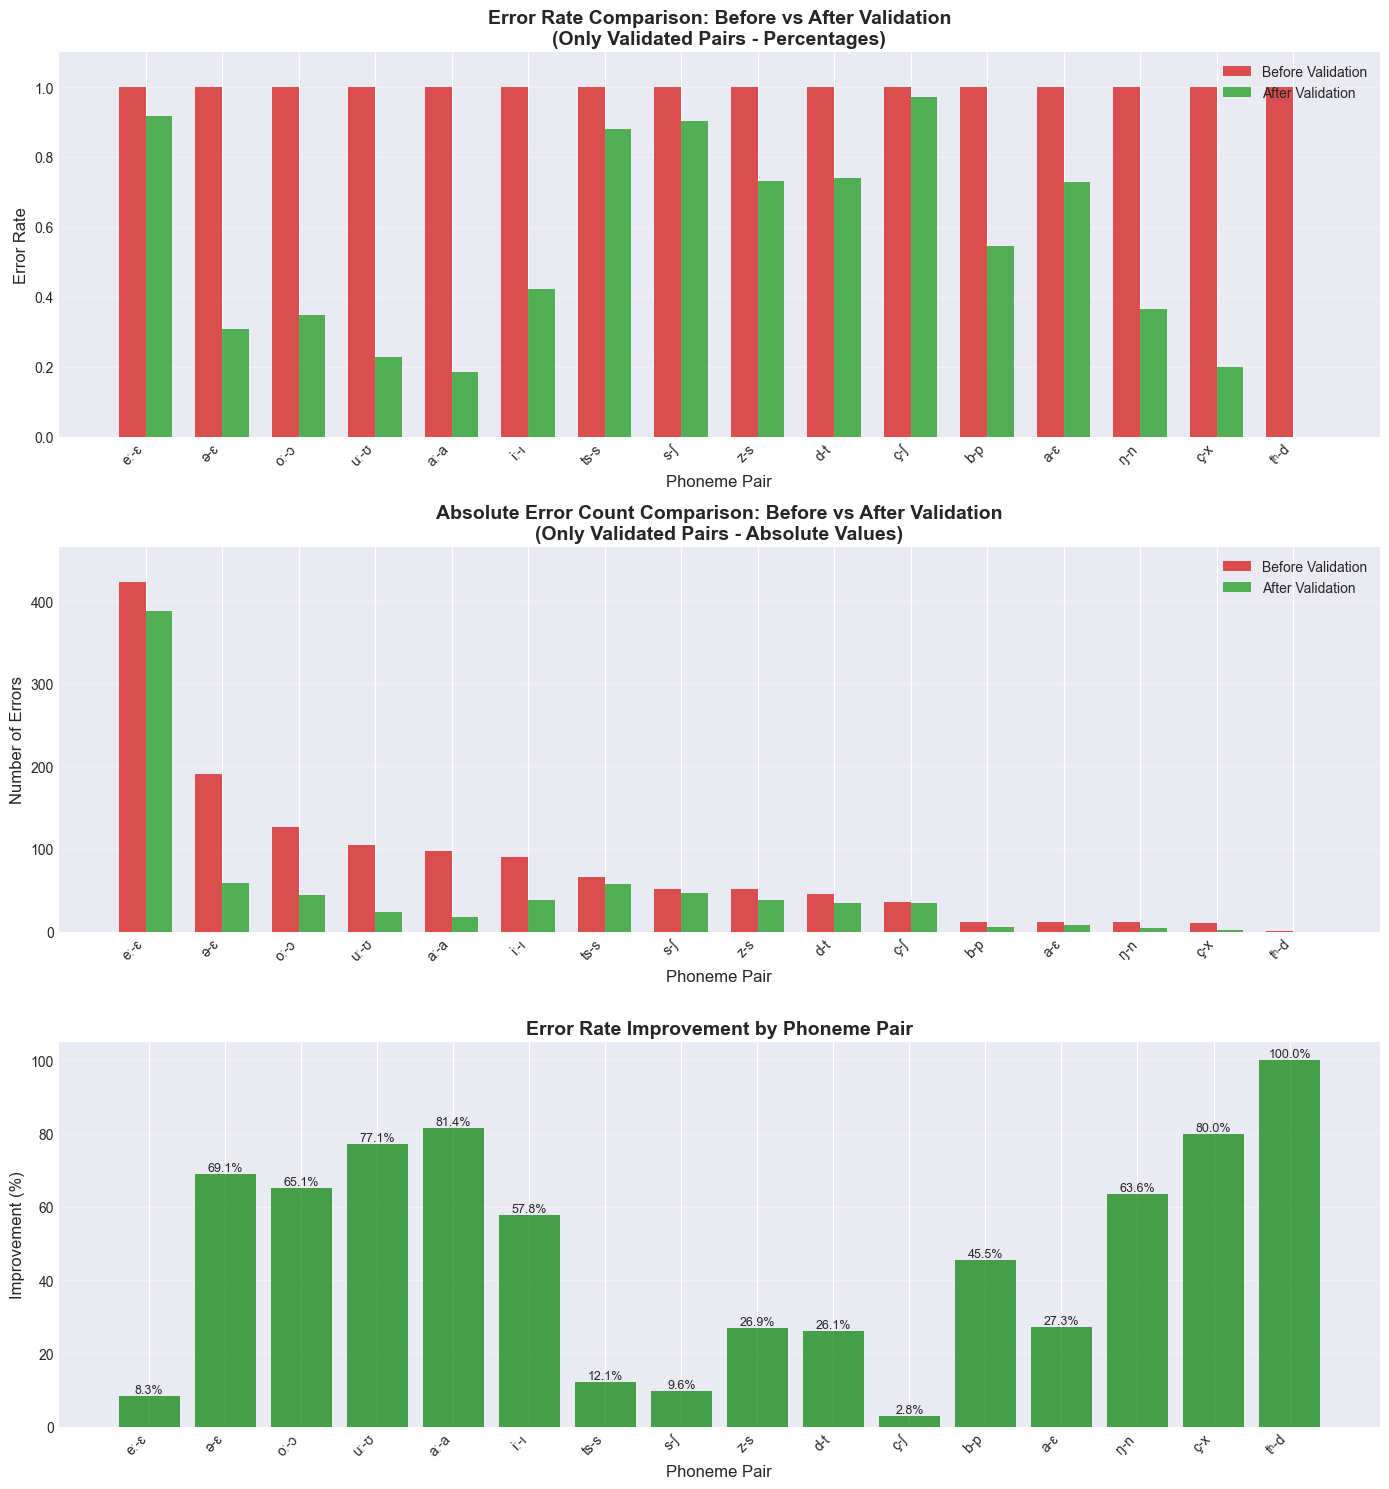


SUMMARY STATISTICS
Pairs with improvement: 16/16
Pairs with no change: 0/16
Pairs with degradation: 0/16

Average improvement: 47.0%
Median improvement: 51.6%
Best improvement: 100.0% (tʰ-d)


In [ ]:
# =============================================================================
# Error Rate Comparison for Validated Phoneme Pairs Only
# =============================================================================
# Compare mismatch rates before and after validation
# Only for the 22 phoneme pairs that have trained models
# =============================================================================

# Get available phoneme pairs from validator
available_pairs = validator.get_available_pairs()
print(f"Available phoneme pairs in validator: {len(available_pairs)}")
print(f"Pairs: {', '.join(sorted(available_pairs))}\n")

# Create a set for fast lookup
available_pairs_set = set(available_pairs)

# Collect mismatch counts for each pair (before and after)
pair_stats = {}

for idx, row in df_sample.iterrows():
    aligned_before = row['aligned_pairs_before']
    aligned_after = row['aligned_pairs_after']
    
    # Count mismatches for each available pair
    for exp, rec in aligned_before:
        # Skip matches, None, or word boundaries
        if exp == rec or exp is None or rec is None:
            continue
        if exp == '||' or rec == '||':
            continue
        
        # Check if this pair is in our available pairs
        # Try both directions: exp-rec and rec-exp
        pair_key = None
        if f"{exp}-{rec}" in available_pairs_set:
            pair_key = f"{exp}-{rec}"
        elif f"{rec}-{exp}" in available_pairs_set:
            pair_key = f"{rec}-{exp}"
        
        if pair_key:
            if pair_key not in pair_stats:
                pair_stats[pair_key] = {'before': 0, 'after': 0, 'total': 0}
            pair_stats[pair_key]['before'] += 1
            pair_stats[pair_key]['total'] += 1
    
    # Count mismatches after validation
    for exp, rec in aligned_after:
        if exp == rec or exp is None or rec is None:
            continue
        if exp == '||' or rec == '||':
            continue
        
        pair_key = None
        if f"{exp}-{rec}" in available_pairs_set:
            pair_key = f"{exp}-{rec}"
        elif f"{rec}-{exp}" in available_pairs_set:
            pair_key = f"{rec}-{exp}"
        
        if pair_key:
            if pair_key not in pair_stats:
                pair_stats[pair_key] = {'before': 0, 'after': 0, 'total': 0}
            pair_stats[pair_key]['after'] += 1

# Create DataFrame for analysis
pair_data = []
for pair, stats in pair_stats.items():
    error_rate_before = stats['before'] / stats['total'] if stats['total'] > 0 else 0.0
    error_rate_after = stats['after'] / stats['total'] if stats['total'] > 0 else 0.0
    improvement = error_rate_before - error_rate_after
    improvement_pct = (improvement / error_rate_before * 100) if error_rate_before > 0 else 0.0
    
    pair_data.append({
        'phoneme_pair': pair,
        'total_occurrences': stats['total'],
        'errors_before': stats['before'],
        'errors_after': stats['after'],
        'error_rate_before': error_rate_before,
        'error_rate_after': error_rate_after,
        'error_rate_improvement': improvement,
        'improvement_percent': improvement_pct
    })

df_pair_comparison = pd.DataFrame(pair_data)
df_pair_comparison = df_pair_comparison.sort_values('total_occurrences', ascending=False)

# Display results
print("="*80)
print("ERROR RATE COMPARISON: Validated Phoneme Pairs Only")
print("="*80)
print(f"\nTotal pairs analyzed: {len(df_pair_comparison)}")
print(f"Total occurrences across all pairs: {df_pair_comparison['total_occurrences'].sum()}")
print(f"Total errors before: {df_pair_comparison['errors_before'].sum()}")
print(f"Total errors after: {df_pair_comparison['errors_after'].sum()}")
print(f"\nOverall error rate before: {df_pair_comparison['errors_before'].sum() / df_pair_comparison['total_occurrences'].sum():.2%}")
print(f"Overall error rate after: {df_pair_comparison['errors_after'].sum() / df_pair_comparison['total_occurrences'].sum():.2%}")
print(f"Overall improvement: {(df_pair_comparison['errors_before'].sum() - df_pair_comparison['errors_after'].sum()) / df_pair_comparison['total_occurrences'].sum():.2%}")
print("="*80)

# Display detailed table
print("\nDetailed comparison by phoneme pair:")
print("-"*80)
display_cols = ['phoneme_pair', 'total_occurrences', 'errors_before', 'errors_after', 
                'error_rate_before', 'error_rate_after', 'error_rate_improvement', 'improvement_percent']
df_display = df_pair_comparison[display_cols].copy()
df_display['error_rate_before'] = df_display['error_rate_before'].apply(lambda x: f"{x:.2%}")
df_display['error_rate_after'] = df_display['error_rate_after'].apply(lambda x: f"{x:.2%}")
df_display['error_rate_improvement'] = df_display['error_rate_improvement'].apply(lambda x: f"{x:.2%}")
df_display['improvement_percent'] = df_display['improvement_percent'].apply(lambda x: f"{x:.1f}%")
df_display.columns = ['Phoneme Pair', 'Total', 'Errors Before', 'Errors After', 
                       'Error Rate Before', 'Error Rate After', 'Improvement', 'Improvement %']
print(df_display.to_string(index=False))
print("-"*80)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Plot 1: Error rates comparison (percentages)
ax1 = axes[0]
x_pos = np.arange(len(df_pair_comparison))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, df_pair_comparison['error_rate_before'], width, 
                label='Before Validation', alpha=0.8, color='#d62728')
bars2 = ax1.bar(x_pos + width/2, df_pair_comparison['error_rate_after'], width,
                label='After Validation', alpha=0.8, color='#2ca02c')

ax1.set_xlabel('Phoneme Pair', fontsize=12)
ax1.set_ylabel('Error Rate', fontsize=12)
ax1.set_title('Error Rate Comparison: Before vs After Validation\n(Only Validated Pairs - Percentages)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(df_pair_comparison['phoneme_pair'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(df_pair_comparison['error_rate_before'].max(), 
                     df_pair_comparison['error_rate_after'].max()) * 1.1])

# Plot 2: Absolute error counts comparison
ax2 = axes[1]
bars3 = ax2.bar(x_pos - width/2, df_pair_comparison['errors_before'], width,
                label='Before Validation', alpha=0.8, color='#d62728')
bars4 = ax2.bar(x_pos + width/2, df_pair_comparison['errors_after'], width,
                label='After Validation', alpha=0.8, color='#2ca02c')

ax2.set_xlabel('Phoneme Pair', fontsize=12)
ax2.set_ylabel('Number of Errors', fontsize=12)
ax2.set_title('Absolute Error Count Comparison: Before vs After Validation\n(Only Validated Pairs - Absolute Values)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_pair_comparison['phoneme_pair'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, max(df_pair_comparison['errors_before'].max(), 
                     df_pair_comparison['errors_after'].max()) * 1.1])

# Plot 3: Improvement percentage
ax3 = axes[2]
colors = ['green' if x > 0 else 'red' for x in df_pair_comparison['improvement_percent']]
bars = ax3.bar(x_pos, df_pair_comparison['improvement_percent'], color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Phoneme Pair', fontsize=12)
ax3.set_ylabel('Improvement (%)', fontsize=12)
ax3.set_title('Error Rate Improvement by Phoneme Pair', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_pair_comparison['phoneme_pair'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, df_pair_comparison['improvement_percent'])):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.1f}%',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Pairs with improvement: {(df_pair_comparison['improvement_percent'] > 0).sum()}/{len(df_pair_comparison)}")
print(f"Pairs with no change: {(df_pair_comparison['improvement_percent'] == 0).sum()}/{len(df_pair_comparison)}")
print(f"Pairs with degradation: {(df_pair_comparison['improvement_percent'] < 0).sum()}/{len(df_pair_comparison)}")
print(f"\nAverage improvement: {df_pair_comparison['improvement_percent'].mean():.1f}%")
print(f"Median improvement: {df_pair_comparison['improvement_percent'].median():.1f}%")
print(f"Best improvement: {df_pair_comparison['improvement_percent'].max():.1f}% ({df_pair_comparison.loc[df_pair_comparison['improvement_percent'].idxmax(), 'phoneme_pair']})")
if (df_pair_comparison['improvement_percent'] < 0).any():
    print(f"Worst change: {df_pair_comparison['improvement_percent'].min():.1f}% ({df_pair_comparison.loc[df_pair_comparison['improvement_percent'].idxmin(), 'phoneme_pair']})")
print("="*80)

## 10. Timecode Comparison: CTC vs MFA

Compare timecodes between CTC and MFA alignment methods to verify they produce different results.

In [ ]:
# =============================================================================
# Timecode Comparison: CTC vs MFA
# =============================================================================
# This cell compares timecodes between CTC and MFA alignment methods
# To use: Load MFA notebook data or run this after loading both datasets

def compare_timecodes_ctc_mfa(df_ctc, df_mfa=None, sample_size=100):
    """
    Compare timecodes between CTC and MFA alignment.
    
    Args:
        df_ctc: DataFrame from CTC notebook with 'recognized_segments'
        df_mfa: DataFrame from MFA notebook with 'recognized_segments' (optional)
        sample_size: Number of files to compare
    """
    
    # If MFA data not provided, try to load from saved file or return None
    if df_mfa is None:
        print("⚠ MFA data not provided. Saving CTC data for later comparison...")
        # Save CTC data for comparison
        ctc_comparison_data = {
            'indices': df_ctc.index[:sample_size].tolist(),
            'segments': {}
        }
        for idx in df_ctc.index[:sample_size]:
            if 'recognized_segments' in df_ctc.columns:
                segments = df_ctc.loc[idx, 'recognized_segments']
                if segments:
                    ctc_comparison_data['segments'][str(idx)] = [
                        {
                            'label': seg.label if hasattr(seg, 'label') else str(seg),
                            'start_time': seg.start_time if hasattr(seg, 'start_time') else 0,
                            'end_time': seg.end_time if hasattr(seg, 'end_time') else 0
                        }
                        for seg in segments if hasattr(seg, 'start_time')
                    ]
        
        import json
        comparison_file = project_root / 'notebooks' / 'ctc_segments_comparison.json'
        with open(comparison_file, 'w') as f:
            json.dump(ctc_comparison_data, f, indent=2)
        print(f"✓ Saved CTC segments to: {comparison_file}")
        print("  Run the same code in MFA notebook to compare.")
        return None
    
    # Sample files for comparison
    common_indices = df_ctc.index.intersection(df_mfa.index)[:sample_size]
    
    if len(common_indices) == 0:
        print("⚠ No common indices found between CTC and MFA dataframes.")
        return None
    
    timecode_differences = []
    segment_counts = {'ctc': [], 'mfa': []}
    duration_differences = []
    
    print(f"Comparing {len(common_indices)} files...")
    
    for idx in tqdm(common_indices, desc="Comparing timecodes"):
        ctc_segments = df_ctc.loc[idx, 'recognized_segments'] if 'recognized_segments' in df_ctc.columns else []
        mfa_segments = df_mfa.loc[idx, 'recognized_segments'] if 'recognized_segments' in df_mfa.columns else []
        
        if not ctc_segments or not mfa_segments:
            continue
        
        # Count segments
        segment_counts['ctc'].append(len(ctc_segments))
        segment_counts['mfa'].append(len(mfa_segments))
        
        # Compare timecodes for matching phonemes
        recognized_ctc = df_ctc.loc[idx, 'recognized_phonemes'] if 'recognized_phonemes' in df_ctc.columns else []
        recognized_mfa = df_mfa.loc[idx, 'recognized_phonemes'] if 'recognized_phonemes' in df_mfa.columns else []
        
        if len(recognized_ctc) != len(recognized_mfa):
            continue
        
        # Compare segments for each phoneme
        min_len = min(len(ctc_segments), len(mfa_segments))
        for i in range(min_len):
            if i < len(ctc_segments) and i < len(mfa_segments):
                ctc_seg = ctc_segments[i]
                mfa_seg = mfa_segments[i]
                
                if hasattr(ctc_seg, 'start_time') and hasattr(mfa_seg, 'start_time'):
                    start_diff = abs(ctc_seg.start_time - mfa_seg.start_time)
                    end_diff = abs(ctc_seg.end_time - mfa_seg.end_time)
                    duration_ctc = ctc_seg.end_time - ctc_seg.start_time
                    duration_mfa = mfa_seg.end_time - mfa_seg.start_time
                    duration_diff = abs(duration_ctc - duration_mfa)
                    
                    timecode_differences.append({
                        'file_idx': idx,
                        'phoneme_idx': i,
                        'phoneme': recognized_ctc[i] if i < len(recognized_ctc) else '?',
                        'start_diff': start_diff,
                        'end_diff': end_diff,
                        'duration_diff': duration_diff,
                        'ctc_start': ctc_seg.start_time,
                        'mfa_start': mfa_seg.start_time,
                        'ctc_end': ctc_seg.end_time,
                        'mfa_end': mfa_seg.end_time,
                        'ctc_duration': duration_ctc,
                        'mfa_duration': duration_mfa
                    })
                    
                    duration_differences.append(duration_diff)
    
    return {
        'timecode_differences': timecode_differences,
        'segment_counts': segment_counts,
        'duration_differences': duration_differences
    }

def plot_timecode_comparison(comparison_data, save_path=None):
    """Plot comparison graphs."""
    
    if comparison_data is None:
        print("No comparison data available.")
        return
    
    timecode_diffs = comparison_data['timecode_differences']
    segment_counts = comparison_data['segment_counts']
    duration_diffs = comparison_data['duration_differences']
    
    if not timecode_diffs:
        print("No timecode differences found. Segments may be identical or data not available.")
        return
    
    df_diffs = pd.DataFrame(timecode_diffs)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('CTC vs MFA Timecode Comparison', fontsize=16, fontweight='bold')
    
    # 1. Start time differences
    axes[0, 0].hist(df_diffs['start_diff'] * 1000, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_xlabel('Start Time Difference (ms)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Start Time Differences')
    mean_start = df_diffs['start_diff'].mean() * 1000
    axes[0, 0].axvline(mean_start, color='red', linestyle='--', 
                       label=f'Mean: {mean_start:.2f} ms')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. End time differences
    axes[0, 1].hist(df_diffs['end_diff'] * 1000, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].set_xlabel('End Time Difference (ms)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of End Time Differences')
    mean_end = df_diffs['end_diff'].mean() * 1000
    axes[0, 1].axvline(mean_end, color='red', linestyle='--',
                       label=f'Mean: {mean_end:.2f} ms')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Duration differences
    axes[0, 2].hist(df_diffs['duration_diff'] * 1000, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].set_xlabel('Duration Difference (ms)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Distribution of Duration Differences')
    mean_dur = df_diffs['duration_diff'].mean() * 1000
    axes[0, 2].axvline(mean_dur, color='red', linestyle='--',
                       label=f'Mean: {mean_dur:.2f} ms')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Segment count comparison
    if segment_counts['ctc'] and segment_counts['mfa']:
        axes[1, 0].bar(['CTC', 'MFA'], 
                       [np.mean(segment_counts['ctc']), np.mean(segment_counts['mfa'])],
                       color=['blue', 'green'], alpha=0.7, edgecolor='black')
        axes[1, 0].set_ylabel('Average Number of Segments')
        axes[1, 0].set_title('Average Segment Count per File')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 5. Scatter: CTC vs MFA start times
    sample_df = df_diffs.sample(min(1000, len(df_diffs)))
    axes[1, 1].scatter(sample_df['ctc_start'] * 1000, sample_df['mfa_start'] * 1000,
                      alpha=0.5, s=10)
    max_val = max(sample_df['ctc_start'].max(), sample_df['mfa_start'].max()) * 1000
    axes[1, 1].plot([0, max_val], [0, max_val], 'r--', label='Perfect match')
    axes[1, 1].set_xlabel('CTC Start Time (ms)')
    axes[1, 1].set_ylabel('MFA Start Time (ms)')
    axes[1, 1].set_title('Start Time: CTC vs MFA')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Scatter: CTC vs MFA durations
    axes[1, 2].scatter(sample_df['ctc_duration'] * 1000, sample_df['mfa_duration'] * 1000,
                      alpha=0.5, s=10, color='orange')
    max_dur = max(sample_df['ctc_duration'].max(), sample_df['mfa_duration'].max()) * 1000
    axes[1, 2].plot([0, max_dur], [0, max_dur], 'r--', label='Perfect match')
    axes[1, 2].set_xlabel('CTC Duration (ms)')
    axes[1, 2].set_ylabel('MFA Duration (ms)')
    axes[1, 2].set_title('Duration: CTC vs MFA')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved comparison plot to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print("TIMECODE COMPARISON SUMMARY")
    print(f"{'='*80}")
    print(f"Total segments compared: {len(df_diffs)}")
    print(f"\nStart Time Differences:")
    print(f"  Mean: {df_diffs['start_diff'].mean()*1000:.2f} ms")
    print(f"  Median: {df_diffs['start_diff'].median()*1000:.2f} ms")
    print(f"  Std: {df_diffs['start_diff'].std()*1000:.2f} ms")
    print(f"  Max: {df_diffs['start_diff'].max()*1000:.2f} ms")
    print(f"\nEnd Time Differences:")
    print(f"  Mean: {df_diffs['end_diff'].mean()*1000:.2f} ms")
    print(f"  Median: {df_diffs['end_diff'].median()*1000:.2f} ms")
    print(f"  Std: {df_diffs['end_diff'].std()*1000:.2f} ms")
    print(f"  Max: {df_diffs['end_diff'].max()*1000:.2f} ms")
    print(f"\nDuration Differences:")
    print(f"  Mean: {df_diffs['duration_diff'].mean()*1000:.2f} ms")
    print(f"  Median: {df_diffs['duration_diff'].median()*1000:.2f} ms")
    print(f"  Std: {df_diffs['duration_diff'].std()*1000:.2f} ms")
    print(f"  Max: {df_diffs['duration_diff'].max()*1000:.2f} ms")
    if segment_counts['ctc'] and segment_counts['mfa']:
        print(f"\nSegment Counts:")
        print(f"  CTC average: {np.mean(segment_counts['ctc']):.1f} segments/file")
        print(f"  MFA average: {np.mean(segment_counts['mfa']):.1f} segments/file")
        print(f"  Difference: {abs(np.mean(segment_counts['ctc']) - np.mean(segment_counts['mfa'])):.1f} segments/file")
    print(f"{'='*80}")

# Run comparison (if MFA data available)
# Uncomment and modify to load MFA data:
# df_mfa = pd.read_pickle('mfa_validation_data.pkl')  # Or load from MFA notebook
# comparison_data = compare_timecodes_ctc_mfa(df_sample, df_mfa, sample_size=100)
# plot_timecode_comparison(comparison_data, save_path=project_root / 'notebooks' / 'timecode_comparison_ctc_mfa.png')

# For now, save CTC data for later comparison
print("Saving CTC segments data for comparison...")
comparison_data_ctc = compare_timecodes_ctc_mfa(df_sample, df_mfa=None, sample_size=100)
print("\n✓ CTC data saved. Load MFA notebook data and run comparison to see differences.")

Saving CTC segments data for comparison...
⚠ MFA data not provided. Saving CTC data for later comparison...
✓ Saved CTC segments to: /Volumes/SSanDisk/SpeechRec-German-diagnostic/notebooks/ctc_segments_comparison.json
  Run the same code in MFA notebook to compare.

✓ CTC data saved. Load MFA notebook data and run comparison to see differences.
